# 13.1 추천 시스템

추천 시스템(recommender system)이란 사용자(user)가 선호하는 상품(item)을 예측하는 시스템이다.

Amazon과 같은 인터넷 쇼핑 사이트나 Netflix 등의 온라인 비디오 콘텐츠 제공 사이트는 사용자가 각각의 상품에 대해 평가한 평점(rate)을 가지고 있다. 이 기록을 기반으로 해서 사용자에게 어떤 상품을 추천할지 예측하게 된다.

### Surprise 패키지

파이썬의 Surprise패키지는 다양한 추천 시스템 알고리즘을 제공한다. 

In [1]:
import surprise

### 평점 데이터

surprise 패키지에서는 MovieLense라는 영화 추천 웹사이트의 데이터를 샘플 평점 데이터로 제공한다. MovieLense 데이터 중 10만개의 샘플 데이터세트는 다음과 같이 로드한다.

In [2]:
data = surprise.Dataset.load_builtin('ml-100k')

이 데이터는 다음과 같이 데이터프레임으로 변환할 수 있다.

In [3]:
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df["id"]
df.head(10)

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
5,298,474,4.0
6,115,265,2.0
7,253,465,5.0
8,305,451,3.0
9,6,86,3.0


여기에서 user 열은 사용자 아이디, item 열은 상품 아이디, rate 열은 평점이다. 즉, 196번 사용자는 242번 영화에 대해 평점 3점을 주었음을 알 수 있다.

이 데이터프레임에서 볼 수 있듯이 

> **추천 시스템은 사용자 아이디와 상품 아이디라는 두 개의 카테고리 입력과 평점 출력을 가지는 예측 시스템**

이다.

이 데이터를 다음과 같이 피봇테이블(pivot table) 형태로 만들면 x축이 상품, y축이 사용자 아이디인 평점 행렬(rate matrix) $R$ 이 된다.

평점 행렬 $R$의 행은 특정 사용자의 평점이고 평점 행렬 $R$의 열은 특정 상품의 평점이다.

In [4]:
df_table = df.set_index(["user", "item"]).unstack()
df_table.shape

(943, 1682)

이 평점 행렬의 일부만 살펴보면 다음과 같이 평점 데이터가 일부 위치에만 존재하는 sparse 행렬임을 알 수 있다.

In [5]:
df_table.iloc[212:222, 808:817].fillna("")

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

평점 행렬의 빈칸을 흰색, 점수를 검은색으로 시각화 하면 다음과 같다.

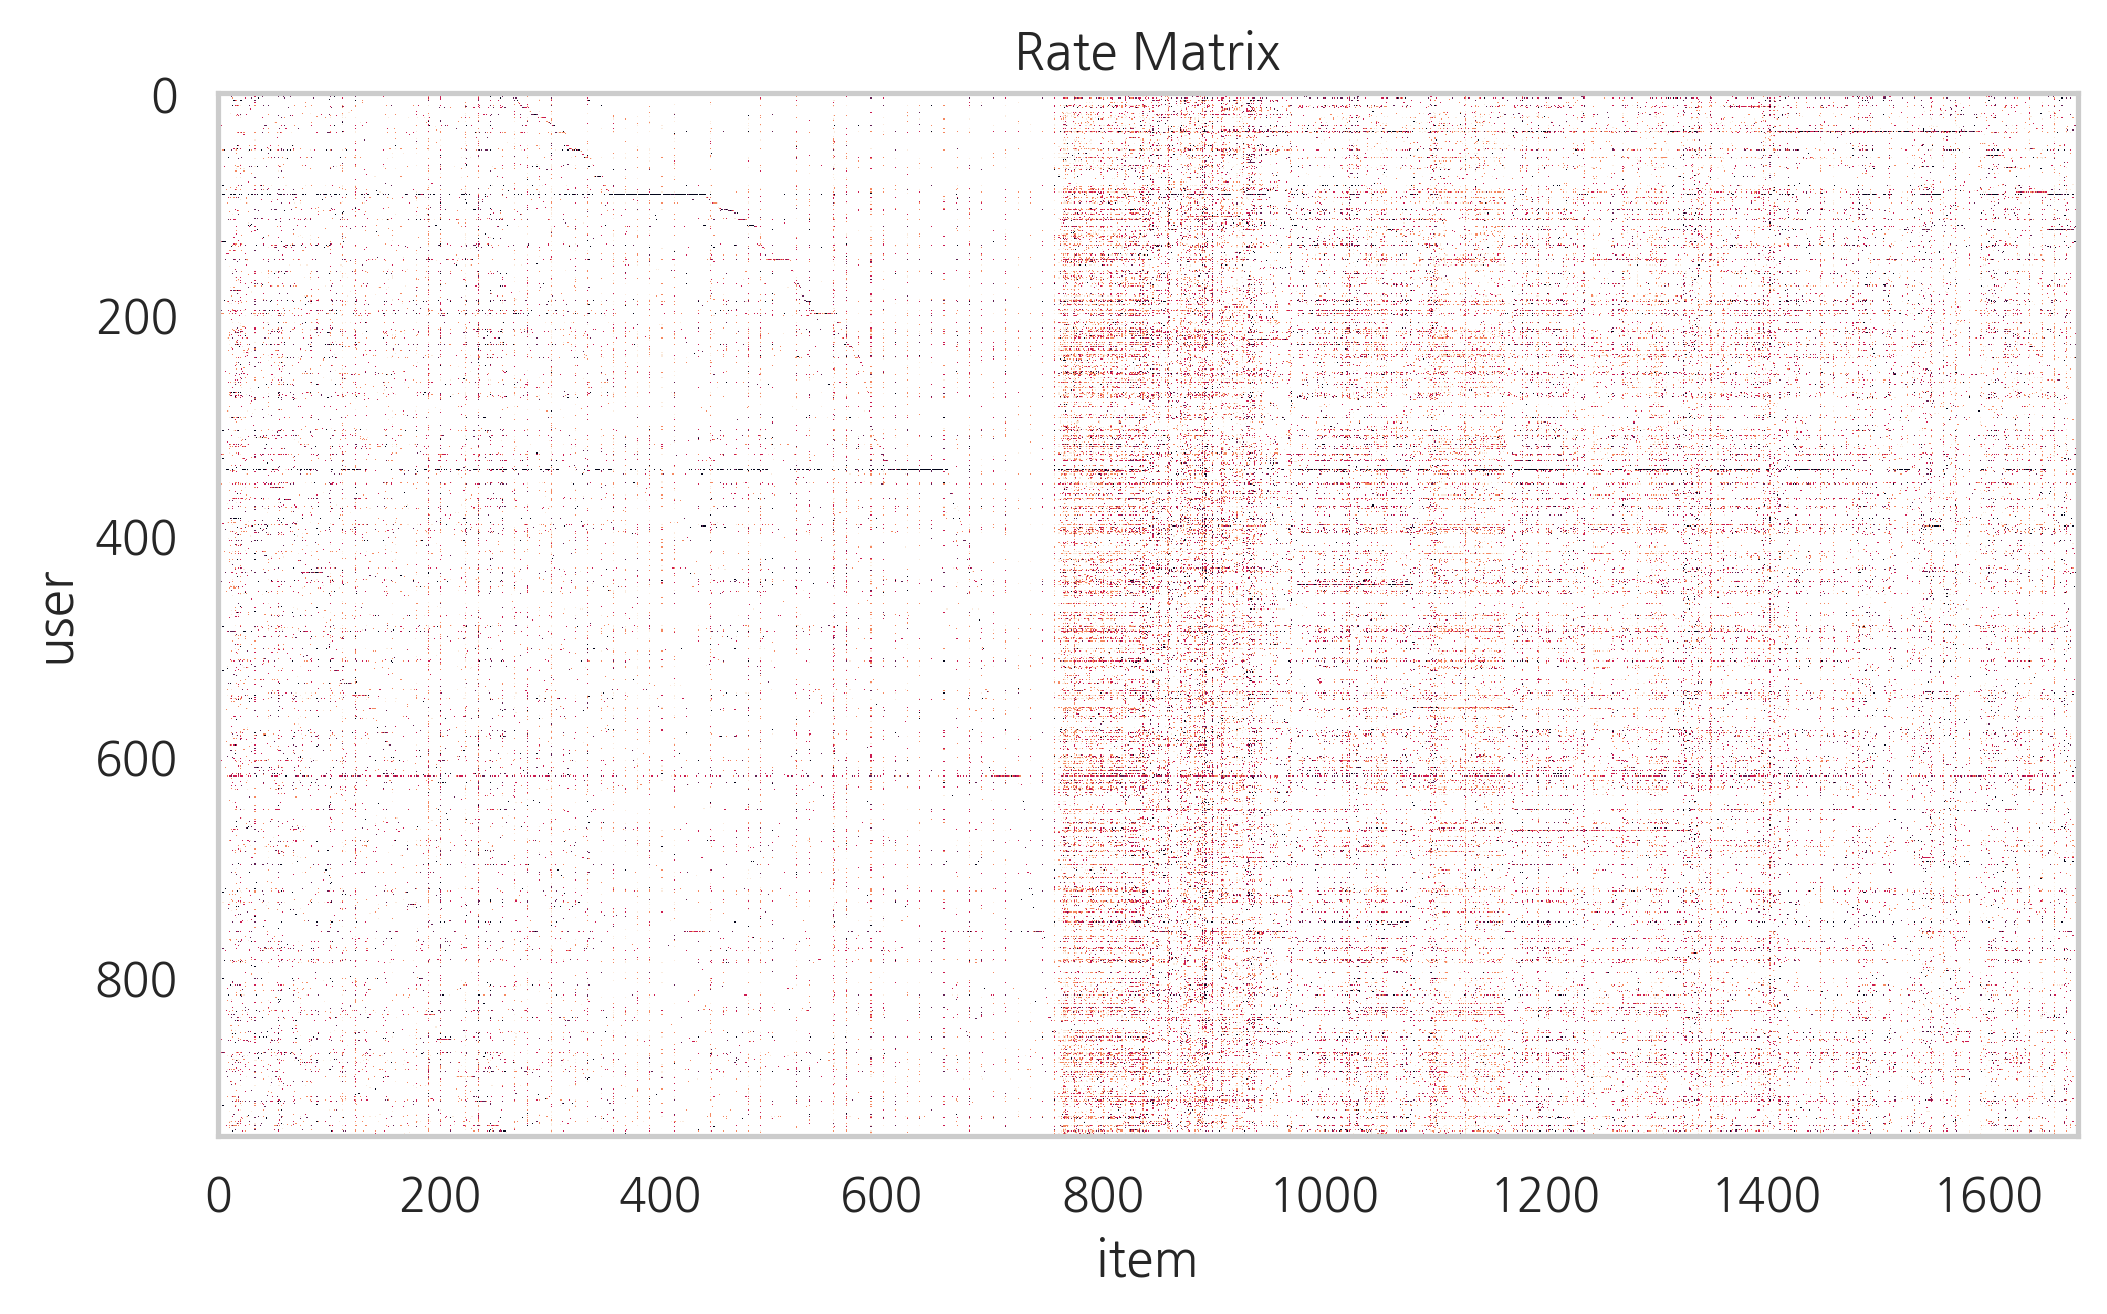

In [6]:
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

### 추천 시스템 알고리즘

추천 시스템은 두 개의 카테고리 값 입력에서 하나의 실수 값 출력을 예측하는 회귀 모형이지만 여러가지 방법으로 예측 성능을 향상시키고 있다. 추천 시스템에서 사용되는 알고리즘은 다음과 같다.

1. 베이스라인 모형
2. Collaborative Filtering
  * 2-1. Neighborhood Models
    * User-based CF
    * Item-based CF
  * 2-2. Latent Factor Models 
    * Matrix Factorization
    * SVD 
3. Content-Based Recommendation

### 베이스라인 모형

베이스라인 모형(baseline model)은 사용자 아이디 $u$, 상품 아이디 $i$, 두 개의 카테고리 값 입력에서 평점 $r(u,i)$의 예측치 $\hat{r}(u,i)$  을 예측하는 가장 단순한 회귀분석모형으로 다음과 같이 사용자와 상품 특성에 의한 평균 평점의 합으로 나타난다.

$$ \hat{r}(u,i) = \mu + b(u) + b(i) $$

이 식에서 $\mu$는 전체 평점의 평균이고, $b(u)$는 동일한 사용자에 의한 평점 조정값,  $b(i)$는 동일한 상품에 대한 평점 조정값이다.

베이스라인 모형은 다음 오차 함수를 최소화하도록 구해진다.

$$ \sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i))\right)^2 $$

여기에서 $R_{train}$는 실제 평점이 존재하는 학습용 데이터 집합이다.

과최적화를 피하기 위해 다음과 같이 정규화 항을 추가할 수 있다.

$$ \sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i))\right)^2 + \lambda \left(b(u)^2 + b(i)^2 \right) $$

surprise 패키지는 오차 함수를 최소화하기 위해 다음과 같은 두 가지 최적화 알고리즘을 제공한다. 알고리즘의 선택은 `method` 인수를 사용한다. 최적화 알고리즘에 따라 나머지 최적화 인수가 달라진다. 


* SGD (Stochastic Gradient Descent)의 인수
  * `reg`: 정규화 가중치. 디폴트는 0.02.
  * `learning_rate`: 최적화 스텝 사이즈. 디폴트는 0.005.
  * `n_epochs`: 최적화 반복 횟수. 디폴트는  20.
  
  
* ALS (Alternating Least Squares)의 인수
  * `reg_i`: 상품에 대한 정규화 가중치. 디폴트는 10.
  * `reg_u`: 사용자에 대한 정규화 가중치. 디폴트는 15.
  * `n_epochs`: 최적화 반복 횟수. 디폴트는 10.

### 모형 사용법

베이스라인 모형을 비롯한 surprise 패키지 모형을 사용하기 위해서는 다음과 같은 순서를 거친다.

1. 데이터세트의 `split`,  `folds` 메소드를 사용하여 K-Fold 트레이닝 데이터셋과 테스트 데이터셋을 만든다.
2. 모형 알고리즘 객체를 생성한다.
3. 모형 알고리즘 객체의 `train` 메서드와 트레이닝 데이터셋으로 모수를 추정한 후, `test` 메서드로 테스트 데이터셋에 대한 예측을 실시한다. 
5. `accuracy` 서브패키지의 성능평가 함수를 사용하여 예측 성능을 계산한다.

이 과정은 `evaluate` 명령으로 단축할 수도 있다.

surprise 패키지는 베이스라인 모형을 위한 `BaselineOnly` 클래스를 제공한다.

우선 베이스라인 모형으로 다음과 같이 MovieLens 데이터를 처리해 보자. FCP(Fraction of Concordant Pairs)로 계산한 평가 점수는 약 0.70점이다.

### 추천성능 평가기준

`accuracy` 서브패키지에서는 다음과 같은 추천성능 평가기준을 제공한다. 이 식에서 $\hat{R}$은 테스트 데이터셋을 뜻한다.

* RMSE (Root Mean Squared Error)
$$ \text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}(u,i) \in \hat{R}}(r(u,i) - \hat{r}(u,i))^2} $$


* MAE (Mean Absolute Error)
$$ \text{MAE} = \dfrac{1}{|\hat{R}|} \sum_{\hat{r}(u,i) \in \hat{R}}|r(u,i) - \hat{r}(u,i)| $$

* FCP (Fraction of Concordant Pairs)
$$ \text{FCP} = \dfrac{\text{number of concordant pairs}}{\text{number of discordant pairs}} $$


회귀 분석에서 $i$번째 데이터와 $j$번째 데이터에 대해 실제 데이터 $y_i, y_j$와 예측 데이터 $\hat{y}_i, \hat{y}_j$ 사이의 증가 방향이 같으면 condordant pair라고 한다.

$$ \text{sign}(y_i - y_j) = \text{sign}(\hat{y}_i - \hat{y}_j) $$


In [7]:
from surprise.model_selection import KFold

bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options)

np.random.seed(0)
acc = np.zeros(3)
cv = KFold(3)
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)
acc.mean()

Estimating biases using als...
RMSE: 0.9453
Estimating biases using als...
RMSE: 0.9377
Estimating biases using als...
RMSE: 0.9500


0.9443304984013942

 `cross_validate` 명령을 사용하면 위 코드를 다음과 같이 단축할 수 있다.

In [8]:
from surprise.model_selection import cross_validate

cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.9384446 , 0.94651657, 0.93612815, 0.94221861, 0.94428787]),
 'test_mae': array([0.74477853, 0.75124267, 0.73975393, 0.745764  , 0.74659098]),
 'fit_time': (0.10585212707519531,
  0.13820195198059082,
  0.1485898494720459,
  0.13920855522155762,
  0.11656451225280762),
 'test_time': (0.21303677558898926,
  0.12261795997619629,
  0.20620155334472656,
  0.12421703338623047,
  0.1168220043182373)}

### Collaborative Filter

CF(Collaborative Filter) 방법은 모든 사용자의 데이터를 균일하게 사용하는 것이 아니라 평점 행렬이 가진 특정한 패턴을 찾아서 이를 평점 예측에 사용하는 방법이다. CF 방법도 사용자나 상품 기준으로 평점의 유사성을 살피는 Neighborhood 모형과 행렬의 수치적 특징을 이용하는 Latent Factor 모형이 있다.


### Neighborhood 모형

Neighborhood 모형은 Memory-based CF라고도 한다. 이 방법은 특정 사용자의 평점을 예측하기 위해 사용하는 것이아니라 해당 사용자와 유사한(similar) 사용자에 대해 가중치를 준다.

특히 해당 사용자와 유사한 사용자를 찾는 방법 즉, 평점 행렬에서 유사한 사용자 행 벡터를 찾아서 이를 기반으로 빈 데이터를 계산하는 방법을 **사용자 기반 (User-based) CF**라고 한다.

이와 달리 특정한 상품에 대해 사용자가 준 점수 즉, 평점 행렬의 상품 열 벡터의 유사성을 찾고 특정 상품과 유사한 평점 정보를 가지는 상품들로 해당 상품의 빈 데이터를 예측하는 방법을 **상품 기반 (Item-based) CF**라고 한다.

### 유사도 계산

사용자 특성 벡터(평점 행렬의 행 벡터)이나 상품 특성 벡터(평점 행렬의 열 벡터)의 유사도(similarity)을 비교하기 위한 기준도 여러가지가 있을 수 있다. 

surprise 패키지에서는 다음과 같은 유사도 기준을 제공한다.

* 평균제곱차이 유사도 (Mean Squared Difference Similarity)
* 코사인 유사도 (Cosine Similarity)
* 피어슨 유사도 (Pearson Similarity)
* 피어슨-베이스라인 유사도 (Pearson-Baseline Similarity)

surprise 패키지의 유사도 설정 옵션은 다음과 같다.

* `name`: 사용할 유사도의 종류를 나타내는 문자열. 디폴트는 `'MSD'`.
* `user_based`: `True`면 사용자 기반, `False`면 상품 기반.
* `min_support`: 두 사용자나, 상품에서 공통적으로 있는 평점 원소의 수의 최솟값. 공통 평점 원소의 수가 이 값보다 적으면 해당 벡터는 사용하지 않는다. 디폴트는 
* `shrinkage`: Shrinkage 가중치. 디폴트는 100.

### 평균제곱차이 유사도

평균제곱차이(Mean Squared Difference, MSD)유사도는 유클리드 공간에서의 거리 제곱에 비례하는 값이다. 일단 다음과 같이 msd값을 구하고 그 역수로 유사도를 정의한다. msd값이 0이 되는 경우를 대비하여 1을 더해준다.

$$ \begin{split}\text{msd_sim}(u, v) &= \frac{1}{\text{msd}(u, v) + 1}\\
\text{msd_sim}(i, j) &= \frac{1}{\text{msd}(i, j) + 1}\end{split} $$

* 사용자 $u$와 사용자 $v$간의 msd

$$ \text{msd}(u, v) = \frac{1}{|I_{uv}|} \cdot \sum\limits_{i \in I_{uv}} (r(u,i) - r_(v,i))^2 $$

위 식에서 $I_{uv}$는 사용자 $u$와 사용자 $v$ 모두에 의해 평가된 상품의 집합이고 $|I_{uv}|$는 사용자 $u$와 사용자 $v$ 모두에 의해 평가된 상품의 수 


* 상품 $i$와 상품 $j$간의 msd

$$ \text{msd}(i, j) = \frac{1}{|U_{ij}|} \cdot \sum\limits_{u \in U_{ij}} (r(u,i) - r(u,j))^2 $$

위 식에서 $U_{ij}$는 상품 $i$와 상품 $j$ 모두를 평가한 사용자의 집합이고 $|U_{ij}|$는 상품 $i$와 상품 $j$ 모두를 평가한 사용자의 수 



In [9]:
sim_options = {'name': 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


0.7726801901092284

### 코사인 유사도

코사인 유사도(Cosine Similarity)는 두 특성 벡터의 각도에 대한 코사인 값을 말한다. 벡터 $x$와 벡터 $y$ 사이의 각도 $\theta$ 는 두 벡터의 내적 $x \cdot y$와 다음과 같은 관계가 있다. 각도 $\theta$가 0도이면 코사인 유사도는 1이다. 반대로 각도 $\theta$가 90도이면 코사인 유사도는 0이다.

$$ x \cdot y = |x| |y| \cos\theta $$

$$ \cos\theta = \dfrac{x \cdot y}{|x| |y|}$$

* 사용자 $u$와 사용자 $v$간의 코사인 유사도

$$ 
\text{cosine_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} r(u,i) \cdot r(v,i)}
{\sqrt{\sum\limits_{i \in I_{uv}} r(u,i)^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} r(v,i)^2}
}
$$


* 상품 $i$와 상품 $j$간의 코사인 유사도

$$ 
\text{cosine_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} r(u,i) \cdot r(u,j)}
{\sqrt{\sum\limits_{u \in U_{ij}} r(u,i)^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} r(u,j)^2}
} 
$$

In [10]:
sim_options = {'name': 'cosine'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


0.8046567723959086

### 피어슨 유사도 

피어슨 유사도(Pearson Similarity)는 두 벡터의 상관계수(Pearson correlation coefficient)를 말하며 다음과 같이 정의한다.

* 사용자 $u$와 사용자 $v$간의 피어슨 유사도

$$ \text{pearson_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} (r(u,i) -  \mu(u)) \cdot (r(v,i) - \mu(v))}
{\sqrt{\sum\limits_{i \in I_{uv}} (r(u,i) -  \mu(u))^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r(v,i) -  \mu(v))^2}
} $$

위 식에서 $\mu(u)$는 사용자 $u$의 평균 평점이다.

* 상품 $i$와 상품 $j$간의 피어슨 유사도

$$
\text{pearson_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} (r(u,i) -  \mu(i)) \cdot (r(u,j) - \mu(j))}
{\sqrt{\sum\limits_{u \in U_{ij}} (r(u,i) -  \mu(i))^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r(u,j) -  \mu(j))^2}
}
$$

위 식에서 $\mu(i)$는 상품 $i$의 평균 평점이다.

상관계수는 가장 높은 경우의 값이 1이고 무상관인 경우에는 0이다.

In [11]:
sim_options = {'name': 'pearson'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


0.8032778978216127

### 피어슨-베이스라인 유사도

피어슨-베이스라인(Pearson-Baseline Similarity) 유사도는 피어슨-베이스라인 유사도와 같이 상관계수를 구하지만 각 벡터의 기댓값을 단순 평균이 아니라 베이스라인 모형에서 예측한 값을 사용한다.

* 사용자 $u$와 사용자 $v$간의 msd

$$ 
\text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
\sum\limits_{i \in I_{uv}} (r(u,i) -  b(u,i)) \cdot (r(v,i) - b(v,i))}
{\sqrt{\sum\limits_{i \in I_{uv}} (r(u,i) -  b(u,i))^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r(v,i) -  b(v,i))^2}} 
$$

* 상품 $i$와 상품 $j$간의 msd

$$
\text{pearson_baseline_sim}(i, j) = \hat{\rho}_{ij} = \frac{
\sum\limits_{u \in U_{ij}} (r(u,i) -  b(u,i)) \cdot (r(u,j) - b(u,j))}
{\sqrt{\sum\limits_{u \in U_{ij}} (r(u,i) -  b(u,i))^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r(u,j) -  b(u,j))^2}}
$$

피어슨-베이스라인 유사도는 벡터의 차원 즉, 두 사용자나 상품에 공통적으로 있는 평점 원소의 갯수를 이용하여 정규화를 하는 shrinkage를 추가하여 사용한다.

$$ 
\begin{split}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}
{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{split} 
$$

$$ \begin{split}\text{pearson_baseline_shrunk_sim}(i, j) &= \frac{|U_{ij}| - 1}
{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}\end{split} 
$$

In [12]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


0.791677323191221

### KNN 가중치 예측 방법

일단 유사도가 구해지면 평점을 예측하고자 하는 사용자(또는 상품)와 유사도가 큰 $k$개의 사용자(또는 상품) 벡터를 사용하여 가중 평균을 구해서 가중치를 예측한다. 이러한 방법을 KNN(K Nearest Neighbors) 기반 예측 방법이라고 한다.

surprise 패키지에서는 다음과 같은 3가지의 KNN 기반 가중치 예측 알고리즘 클래스를 제공한다.



* `KNNBasic`
  * 평점들을 단순히 가중 평균한다. 다음 식에서 $N^k$는 $k$개의 가장 유사도가 큰 벡터의 집합이다.
  
$$  
\hat{r}(u,i) = \frac{
        \sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r(v,i)}
        {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)}
$$
또는
$$
\hat{r}(u,i) = \frac{
        \sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r(u,j)}
        {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)}
$$


* `KNNWithMeans`
  * 평점들을 평균값 기준으로 가중 평균한다.
  
$$  
\hat{r}(u,i) = \mu(u) + 
\frac{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot (r(v,i) - \mu(v))}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)}
$$

또는

$$
\hat{r}(u,i) = \mu(i) + 
\frac{\sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r(u,j) - \mu(j))} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)}
$$

* `KNNBaseline`
  * 평점들을 베이스라인 모형의 값 기준으로 가중 평균한다.
  
$$  
\hat{r}(u,i) = b(u,i) + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r(v,i) - b(v,i))} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$
또는
$$
\hat{r}(u,i) = b(u,i) + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r(u,j) - b(u,j))} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}
$$



In [13]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNWithMeans(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


0.7299485648439766

In [14]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBaseline(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


0.7211170375266851

### Latent Factor 모형

사용자의 특성 벡터나 상품의 특성 벡터의 길이는 수천에서 수십억에 달하는 긴 크기가 될 수도 있다. 

Latent Factor 모형은 이렇게 긴 사용자 특성이나 상품 특성을 몇 개의 요인 벡터로 간략화(approximate)할 수 있다는 가정에서 출발한 모형이다.  
PCA(Principle Component Analysis)를 사용하면 긴 특성 벡터를 소수의 차원으로 차원 축소할 수 있듯이 사용자의 특성도 차원 축소 할 수 있다. 

영화에 대한 평점을 주는 경우, 코미디, 액션, 드라마 등 몇개의 장르 요인이 있어서 사용자는 특정한 장르 요소에 대해 더 점수를 많이 주거나 적게 줄 수 있다. 그리고 영화 자체도 이러한 장르 요인을 가지고 있다면 해당 사용자의 그 영화에 대한 평점은 사용자의 장르 요인 벡터와 영화의 장르 요인 벡터의 내적으로 표시할 수 있다. 

예를 들어 액션을 싫어하고(-1) 코미디(2)나 드라마(3)를 좋아하는 사용자의 요인 벡터는 다음과 같다.

$$ p(u)^T = (-1, 2, 3) $$


어떤 영화가 액션 요소가 2이고 코미디 요소가 1이고, 드라마 요소가 1이라면 

$$ q(i)^T = (2, 1, 1) $$


평점은 다음과 같을 것이다. 

$$ r(u,i) = q(i)^Tp(u) = -1 \cdot 2 + 2 \cdot 1 + 3 \cdot 1 = 3$$

### Matrix Factorization

Matrix Factorization 방법은 모든 사용자와 상품에 대해 다음 오차 함수를 최소화하는 요인 벡터를 찾아낸다. 즉 다음과 같은 행렬 $P$, $Q$를 찾는다.

$$ R \approx PQ^T  $$

여기에서 
* $R \in \mathbf{R}^{m \times n}$ : $m$ 사용자와 $n$ 상품의 평점 행렬
* $P \in \mathbf{R}^{m \times k}$ : $m$ 사용자와 $k$ 요인의 관계 행렬
* $Q \in \mathbf{R}^{n \times k}$ : $n$ 상품의와 $k$ 요인의 관계 행렬

### SVD (Singular Value Decomposition) 

SVD (Singular Value Decomposition) 는 Matrix Factorization 문제를 푸는 방법 중 하나이다. 

$m \times n$ 크기의 행렬 $R$은 다음과 같이 세 행렬의 곱으로 나타낼 수 있다. 이를 특이치 분해(Singular Value Decomposition) 라고 한닫. 

$$ R =  U \Sigma V^T $$

이 식에서 
* $U$ 는 $m \times m$ 크기의 행렬로 역행렬이 대칭 행렬 
* $\Sigma$ 는 $m \times n$ 크기의 행렬로 비대각 성분이 0
* $V$ 는 $n \times n$ 크기의 행렬로 역행렬이 대칭 행렬

$\Sigma$의 대각 성분은 특이치라고 하며 전체 특이치 중에서 가장 값이 큰 $k$개의 특이치만을 사용하여 (Truncated SVD), 다음과 같은 행렬을 만들수 있다.

* $\hat{U}$ 는 $U$에서 가장 값이 큰 $k$개의 특이치에 대응하는 $k$개의 성분만을 남긴 $m \times k$ 크기의 행렬 
* $\hat{\Sigma}$ 는 가장 값이 큰 $k$개의 특이치에 대응하는 $k$개의 성분만을 남긴 $k \times k$ 크기의 대각 행렬 
* $\hat{V}$ 는 $V$에서 가장 값이 큰 $k$개의 특이치에 대응하는 $k$개의 성분만을 남긴 $k \times n$ 크기의 행렬

이 행렬을 다시 조합하면 원래의 행렬과 같은 크기를 가지고 유사한 원소를 가지는 행렬을 만들 수 있다. 

$$ \hat{U} \hat{\Sigma} \hat{V}^T =  \hat{R} \approx R $$


하지만 실제로 평점 행렬은 빈 원소가 많은 sparse 행렬로서 SVD를 바로 적용하기 힘들기 때문에  행렬 $P$, $Q$는  다음과 같은 모형에 대해  오차 함수를 최소화하여 구한다.


$$ 
\hat{r}(u,i) = \mu + b(u) + b(i) + q(i)^Tp(u) 
$$

$$ 
\sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i) \right)^2 +
\lambda\left(b(i)^2 + b(u)^2 + ||q(i)||^2 + ||p(u)||^2\right) 
$$


In [15]:
%%time
algo = surprise.SVD(n_factors=100)
cross_validate(algo, data)["test_mae"].mean()

CPU times: user 30.4 s, sys: 50 ms, total: 30.4 s
Wall time: 30.5 s


0.739210803693828

### NMF(Non-negative matrix factorization)

In [16]:
%%time
algo = surprise.NMF(n_factors=100)
cross_validate(algo, data)["test_mae"].mean()

CPU times: user 1min 24s, sys: 330 ms, total: 1min 24s
Wall time: 1min 25s


0.8371368390504086